# Ambulance Call Outs DCC

> Dublin Ambulance (DA) annual incident activity logs [dataset](https://data.smartdublin.ie/dataset/fire-brigade-and-ambulance)

Main fields:
- Date
- Area of incident (district ID)
- Response time data

Additial fields:
- **Time of call** (TOC) is the time the call is received in the control center
- **Ordered time** (ORD) is the time the vehicle is ordered (i.e. mobilised to the incident by a control operator)
- **Mobile to incident** (MOB) is the time at which the vehicle is mobile to the incident (the vehicle has started to move)
- **In attendance** (IA) is the time the vehicle is in attendance (the vehicle is stopped at the incident)
- **Leaving scene** (LS) is the time the ambulance is leaving scene for hospital
- **At hospital** (AH) is the time which the ambulance has arrived at hospital
- **Mobile and available** (MAV) is the time at which the vehicle is mobile and available (vehicle heading back to station)
- **Closing down** (CD) is the time at which the vehicle is closing down (back at station, vehicle radio is being shut down)

The fields from MOB through to CD are generated by the vehicle (either by a button press or a voice message) and they reflect its changing status.

Ambulance names:
- **Echo**: life threatening, cardiac or respiratory arrest
- **Delta**: life threatening other than cardiac or respiratory arrest
- **Charlie**: serious not life threatening immediate
- **Bravo**: serious not life threatening urgent
- **Alpha**: non serious or life threatening
- **Omega**: minor illness or injury

## 1. Data loading

- Import the necessary libraries, including pm4py
- Load your dataset into a pandas DataFrame or any suitable data structure

In [1]:
%pip install -q -U pm4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import pm4py

import urllib.request

In [3]:
def read_csv_from_url(url):
  csv_data = pd.read_csv(url)

  return csv_data

In [4]:
ambulance_url = "https://data.smartdublin.ie/dataset/19a0948f-9505-49db-b399-226a8bcc1493/resource/e1c6721b-09c3-4e2a-bb27-b37ca75a9fed/download/dccfirebrigadeambulanceincidents2012.csv"

ambulance_data = read_csv_from_url(ambulance_url)

In [5]:
print(f"Numbers of events for ambulance_data: {len(ambulance_data)}")

Numbers of events for ambulance_data: 71414


In [6]:
ambulance_data.head()

,Date,Station Area,Description,TOC,ORD,MOB,IA,LS,AH,MAV,CD
0,01/01/2012 00:12,Dolphins Barn,Delta,01/01/2012 00:12,01/01/2012 00:14,01/01/2012 00:14,01/01/2012 00:17,01/01/2012 00:20,NaN,01/01/2012 00:30,01/01/2012 00:32
1,01/01/2012 00:13,Dolphins Barn,Alpha,01/01/2012 00:13,01/01/2012 00:16,01/01/2012 00:17,01/01/2012 00:23,NaN,01/01/2012 00:38,01/01/2012 00:47,01/01/2012 00:51
2,01/01/2012 00:20,Phibsboro,Omega,01/01/2012 00:20,01/01/2012 00:24,01/01/2012 00:26,01/01/2012 00:31,01/01/2012 00:42,01/01/2012 00:46,01/01/2012 00:55,01/01/2012 01:04
3,01/01/2012 00:27,Kilbarrack,Bravo,01/01/2012 00:27,01/01/2012 00:29,01/01/2012 00:31,NaN,NaN,01/01/2012 00:45,01/01/2012 00:59,01/01/2012 01:00
4,01/01/2012 00:30,Dolphins Barn,Bravo,01/01/2012 00:30,01/01/2012 00:32,01/01/2012 00:32,NaN,NaN,NaN,01/01/2012 00:44,01/01/2012 00:45


---

As we can see, we have a lot of timestamps for every action of the ambulance. We need to convert those timestamps to activities as it follows:

| Column name | Activity name | Description |
|---|---|---|
| TOC | TimeOfCall | The time the call is received in the control center |
| ORD | OrderedTime | The time the vehicle is ordered (i.e. mobilised to the incident by a control operator) |
| MOB | MobileToIncident | The time at which the vehicle is mobile to the incident (the vehicle has started to move) |
| IA | InAttendance | The time the vehicle is in attendance (the vehicle is stopped at the incident) |
| LS | LeavingScene | The time the ambulance is leaving scene for hospital |
| AH | AtHospital | The time which the ambulance has arrived at hospital |
| MAV | MobileAndAvailable | The time at which the vehicle is mobile and available (vehicle heading back to station) |
| CD | ClosingDown | The time at which the vehicle is closing down (back at station, vehicle radio is being shut down) |

The standard procedure of dispatch should be:

1. Time of call + Ordered Time
2. Mobile to incident
3. In attendance
4. Leaving scene
5. At hospital
6. Mobile and available
7. Closing down

It could happen that the procedure can be modified, due to additional information from the call in the control center:

1. Time of call + Ordered Time
2. Mobile to incident
3. Mobile and available
4. Closing down

It could also happen that there is no need to bring a person to the hospital:

1. Time of call + Ordered Time
2. Mobile to incident
3. In attendance
4. Leaving scene
5. Mobile and available
6. Closing down

We will analyze **Echo**'s activity, for life threatening, cardiac or respiratory arrest incidents, that are more serious and usually requires the standard procedure.



## 2. Data preprocessing

- Clean and preprocessing data
- Ensuring that the dataset has appropriate columns like `case_id`, `activity`, `timestamp`

In this case, we **cannot** remove `NaN` data because can happen that an ambulance has different orders during the task.

In [7]:
# check for null values
print(f"Numbers of events for ambulance_data: {len(ambulance_data)}")
print(ambulance_data.isnull().sum())

Numbers of events for ambulance_data: 71414
Date                0
Station Area        0
Description         0
TOC                 0
ORD                 0
MOB              1350
IA              10916
LS              21514
AH              20613
MAV              3067
CD                  0
dtype: int64


In [8]:
# # drop rows with empty columns
# ambulance_data = ambulance_data.dropna()
# print(f"Numbers of events for ambulance_data: {len(ambulance_data)}")
# print(ambulance_data.isnull().sum())

In [9]:
# format all data columns
date_columns = ['Date', 'TOC', 'ORD', 'MOB', 'IA', 'LS', 'AH', 'MAV', 'CD']

date_format = "%d/%m/%Y %H:%M"

ambulance_data[date_columns] = ambulance_data[date_columns].apply(lambda x: pd.to_datetime(x, format=date_format))
print(ambulance_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71414 entries, 0 to 71413
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          71414 non-null  datetime64[ns]
 1   Station Area  71414 non-null  object        
 2   Description   71414 non-null  object        
 3   TOC           71414 non-null  datetime64[ns]
 4   ORD           71414 non-null  datetime64[ns]
 5   MOB           70064 non-null  datetime64[ns]
 6   IA            60498 non-null  datetime64[ns]
 7   LS            49900 non-null  datetime64[ns]
 8   AH            50801 non-null  datetime64[ns]
 9   MAV           68347 non-null  datetime64[ns]
 10  CD            71414 non-null  datetime64[ns]
dtypes: datetime64[ns](9), object(2)
memory usage: 6.0+ MB
None


In [10]:
ambulances_types = ambulance_data['Description'].unique()
print('Ambulance names\n', ambulances_types)

Ambulance names
 ['Delta' 'Alpha' 'Omega' 'Bravo' 'Charlie' '999/112 Incident Non ProQa'
 'Echo']


We remove `999/112 Incident Non ProQa` because it's a special type of call that does not follow the basic procedure for the ambulance type, but it will deploy the first one close to the incident.

In [11]:
# drop 999/112 Incident Non ProQa rows
description_to_drop = '999/112 Incident Non ProQa'

ambulance_data = ambulance_data[ambulance_data['Description'] != description_to_drop]
ambulance_data.reset_index(drop=True, inplace=True)

print(f"Numbers of events for ambulance_data: {len(ambulance_data)}")

Numbers of events for ambulance_data: 66632


In [12]:
ambulance_data.head()

,Date,Station Area,Description,TOC,ORD,MOB,IA,LS,AH,MAV,CD
0,2012-01-01 00:12:00,Dolphins Barn,Delta,2012-01-01 00:12:00,2012-01-01 00:14:00,2012-01-01 00:14:00,2012-01-01 00:17:00,2012-01-01 00:20:00,NaT,2012-01-01 00:30:00,2012-01-01 00:32:00
1,2012-01-01 00:13:00,Dolphins Barn,Alpha,2012-01-01 00:13:00,2012-01-01 00:16:00,2012-01-01 00:17:00,2012-01-01 00:23:00,NaT,2012-01-01 00:38:00,2012-01-01 00:47:00,2012-01-01 00:51:00
2,2012-01-01 00:20:00,Phibsboro,Omega,2012-01-01 00:20:00,2012-01-01 00:24:00,2012-01-01 00:26:00,2012-01-01 00:31:00,2012-01-01 00:42:00,2012-01-01 00:46:00,2012-01-01 00:55:00,2012-01-01 01:04:00
3,2012-01-01 00:27:00,Kilbarrack,Bravo,2012-01-01 00:27:00,2012-01-01 00:29:00,2012-01-01 00:31:00,NaT,NaT,2012-01-01 00:45:00,2012-01-01 00:59:00,2012-01-01 01:00:00
4,2012-01-01 00:30:00,Dolphins Barn,Bravo,2012-01-01 00:30:00,2012-01-01 00:32:00,2012-01-01 00:32:00,NaT,NaT,NaT,2012-01-01 00:44:00,2012-01-01 00:45:00


Now we need to build a new dataset, starting from this one, that for every ambulance describes its actions through the time using the columns TOC, ORD, MOB, IA, LS, AH, MAV, CD.

Refer to this link for [Pandas `.loc` error solution](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy)

In [13]:
pd.options.mode.copy_on_write = True

In [14]:
# extract TOC (Time of Call) data
toc_cols = ['Date', 'Station Area', 'Description', 'TOC']
toc_data = ambulance_data[toc_cols]
toc_data.loc[:, 'Activity'] = "TimeOfCall"

toc_data['Date'] = toc_data['TOC']
toc_data.drop(columns=['TOC'], inplace=True)

toc_data = toc_data.dropna()

In [15]:
toc_data['Date'].isnull().sum()

0

In [16]:
# extract ORD (Ordered time) data
ord_cols = ['Date', 'Station Area', 'Description', 'ORD']
ord_data = ambulance_data[ord_cols]
ord_data.loc[:, 'Activity'] = "OrderedTime"

ord_data['Date'] = ord_data['ORD']
ord_data.drop(columns=['ORD'], inplace=True)

ord_data = ord_data.dropna()

In [17]:
ord_data['Date'].isnull().sum()

0

In [18]:
# extract MOB (Mobile on incident) data
mob_cols = ['Date', 'Station Area', 'Description', 'MOB']
mob_data = ambulance_data[mob_cols]
mob_data.loc[:, 'Activity'] = "MobileToIncident"

mob_data['Date'] = mob_data['MOB']
mob_data.drop(columns=['MOB'], inplace=True)

mob_data = mob_data.dropna()

In [19]:
mob_data['Date'].isnull().sum()

0

In [20]:
# extract IA (In attendance) data
ia_cols = ['Date', 'Station Area', 'Description', 'IA']
ia_data = ambulance_data[ia_cols]
ia_data.loc[:, 'Activity'] = "InAttendance"

ia_data['Date'] = ia_data['IA']
ia_data.drop(columns=['IA'], inplace=True)

ia_data = ia_data.dropna()

In [21]:
ia_data['Date'].isnull().sum()

0

In [22]:
# extract LS (Leaving scene) data
ls_cols = ['Date', 'Station Area', 'Description', 'LS']
ls_data = ambulance_data[ls_cols]
ls_data.loc[:, 'Activity'] = "LeavingScene"

ls_data['Date'] = ls_data['LS']
ls_data.drop(columns=['LS'], inplace=True)

ls_data = ls_data.dropna()

In [23]:
ls_data['Date'].isnull().sum()

0

In [24]:
# extract AH (At hospital) data
ah_cols = ['Date', 'Station Area', 'Description', 'AH']
ah_data = ambulance_data[ah_cols]
ah_data.loc[:, 'Activity'] = "AtHospital"

ah_data['Date'] = ah_data['AH']
ah_data.drop(columns=['AH'], inplace=True)

ah_data = ah_data.dropna()

In [25]:
ah_data['Date'].isna().sum()

0

In [26]:
# extract MAV (Mobile and available) data
mav_cols = ['Date', 'Station Area', 'Description', 'MAV']
mav_data = ambulance_data[mav_cols]
mav_data.loc[:, 'Activity'] = "MobileAndAvailable"

mav_data['Date'] = mav_data['MAV']
mav_data.drop(columns=['MAV'], inplace=True)

mav_data = mav_data.dropna()

In [27]:
mav_data['Date'].isnull().sum()

0

In [28]:
# extract CD (Closed down) data
cd_cols = ['Date', 'Station Area', 'Description', 'CD']
cd_data = ambulance_data[cd_cols]
cd_data.loc[:, 'Activity'] = "ClosingDown"

cd_data['Date'] = cd_data['CD']
cd_data.drop(columns=['CD'], inplace=True)

cd_data = cd_data.dropna()

In [29]:
cd_data['Date'].isnull().sum()

0

In [30]:
list_of_actions = [toc_data, ord_data, mob_data, ia_data, ls_data, ah_data, mav_data, cd_data]
action_log = pd.concat(list_of_actions, ignore_index=True)
action_log

,Date,Station Area,Description,Activity
0,2012-01-01 00:12:00,Dolphins Barn,Delta,TimeOfCall
1,2012-01-01 00:13:00,Dolphins Barn,Alpha,TimeOfCall
2,2012-01-01 00:20:00,Phibsboro,Omega,TimeOfCall
3,2012-01-01 00:27:00,Kilbarrack,Bravo,TimeOfCall
4,2012-01-01 00:30:00,Dolphins Barn,Bravo,TimeOfCall
...,...,...,...,...
481360,2013-01-01 00:13:00,Donnybrook,Charlie,ClosingDown
481361,2013-01-01 01:07:00,North Strand,Charlie,ClosingDown
481362,2013-01-01 00:44:00,Blanchardstown,Delta,ClosingDown
481363,2013-01-01 00:14:00,Phibsboro,Delta,ClosingDown


## 3. Data Exploration

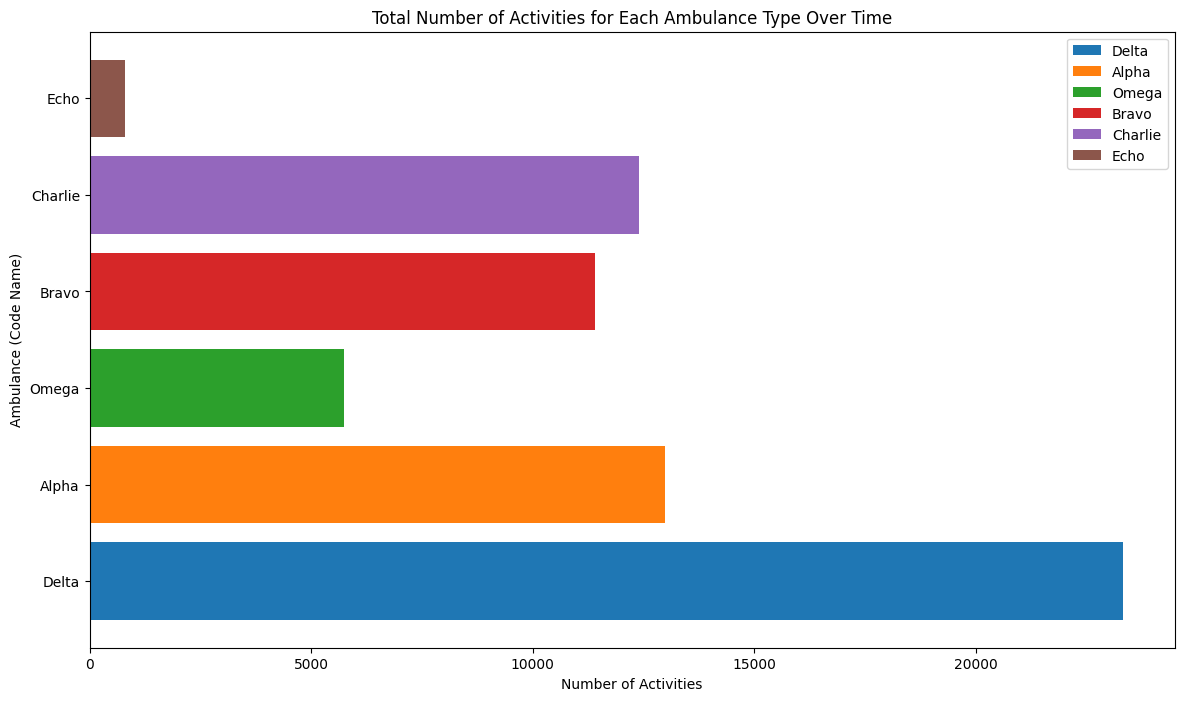

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Ambulance_Type' is the column containing the ambulance type
ambulance_types = ambulance_data['Description'].unique()

plt.figure(figsize=(14, 8))

# Plot the total count of activities for each ambulance type
for ambulance_type in ambulance_types:
    subset = ambulance_data[ambulance_data['Description'] == ambulance_type]
    activity_counts = subset['TOC'].dt.date.value_counts().sort_index()
    plt.barh(ambulance_type, activity_counts.sum(), label=ambulance_type)

plt.title('Total Number of Activities for Each Ambulance Type Over Time')
plt.xlabel('Number of Activities')
plt.ylabel('Ambulance (Code Name)')
plt.legend()
plt.show()

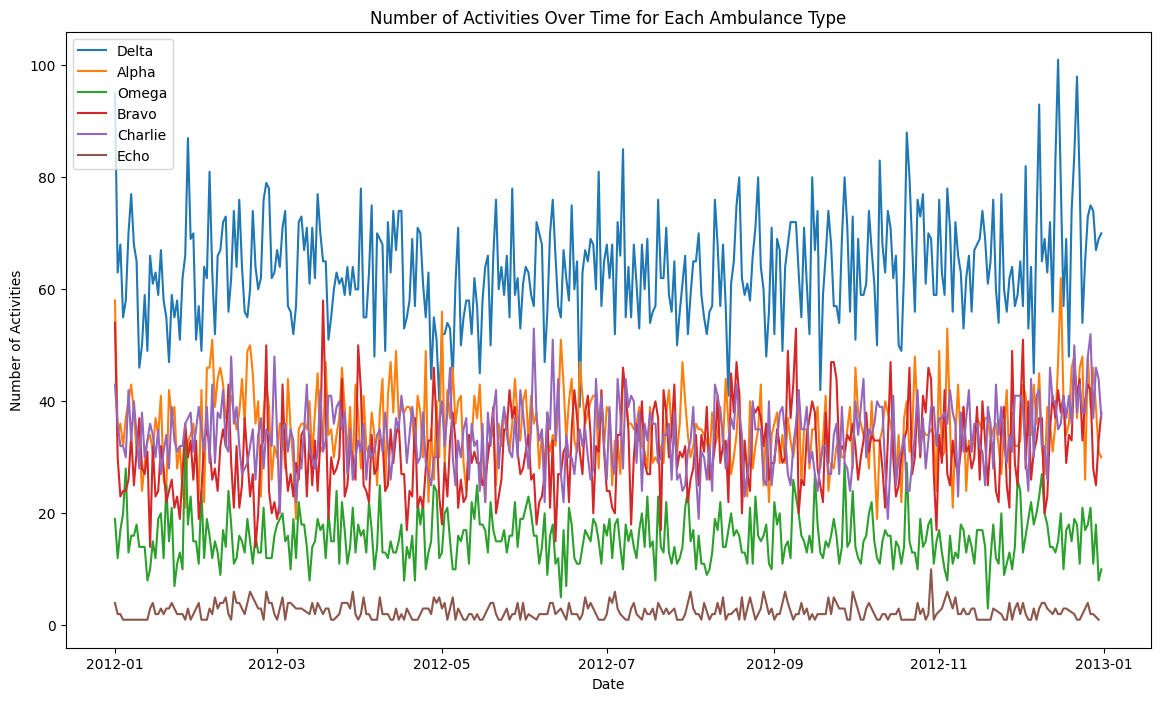

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Ambulance_Type' is the column containing the ambulance type
ambulance_types = ambulance_data['Description'].unique()

plt.figure(figsize=(14, 8))

# Plot the count of activities for each ambulance type
for ambulance_type in ambulance_types:
    subset = ambulance_data[ambulance_data['Description'] == ambulance_type]
    activity_counts = subset['TOC'].dt.date.value_counts().sort_index()
    plt.plot(activity_counts.index, activity_counts.values, label=ambulance_type)

plt.title('Number of Activities Over Time for Each Ambulance Type')
plt.xlabel('Date')
plt.ylabel('Number of Activities')
plt.legend()
plt.show()

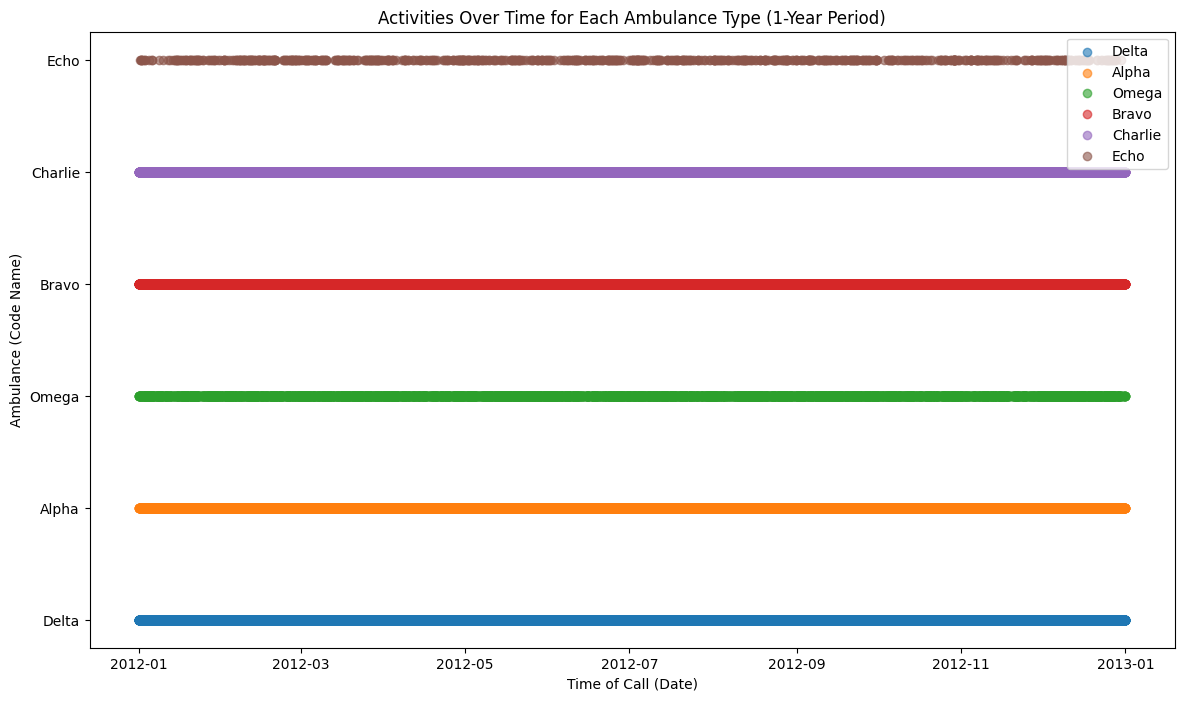

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Ambulance_Type' is the column containing the ambulance type
ambulance_types = ambulance_data['Description'].unique()

plt.figure(figsize=(14, 8))

# Plot individual data points for each activity
for ambulance_type in ambulance_types:
    subset = ambulance_data[ambulance_data['Description'] == ambulance_type]
    plt.scatter(subset['Date'], [ambulance_type] * len(subset), label=ambulance_type, alpha=0.6)

plt.title('Activities Over Time for Each Ambulance Type (1-Year Period)')
plt.xlabel('Time of Call (Date)')
plt.yticks(ticks=range(len(ambulance_types)), labels=ambulance_types)
plt.ylabel('Ambulance (Code Name)')
plt.legend()
plt.show()

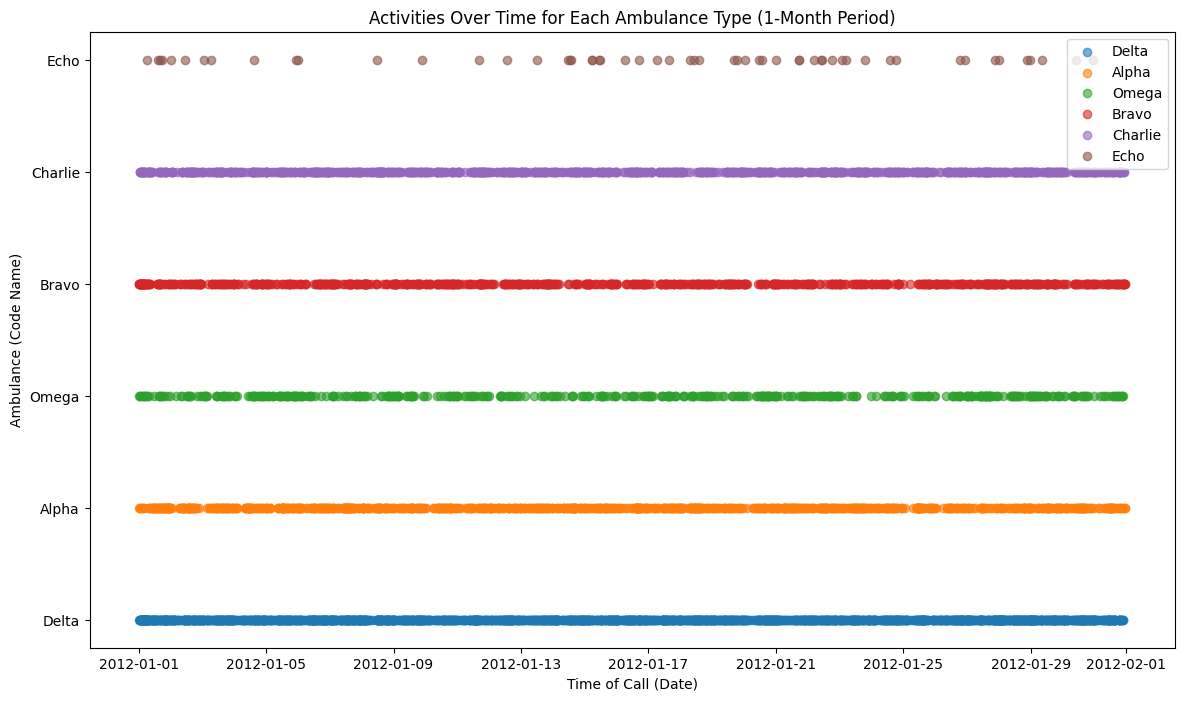

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

ambulance_types = action_log['Description'].unique()

start_date = '2012-01-01 00:00:00'
end_date = '2012-01-31 23:59:59'

# 1-month data for every ambulance
month_filtered_data = action_log.loc[(action_log['Date'] >= start_date) & (action_log['Date'] <= end_date) & (action_log['Activity'] == 'TimeOfCall')]

plt.figure(figsize=(14, 8))

# plot data
for ambulance_type in ambulance_types:
    subset = month_filtered_data.loc[month_filtered_data['Description'] == ambulance_type]
    plt.scatter(subset['Date'], [ambulance_type] * len(subset), label=ambulance_type, alpha=0.6)

plt.title('Activities Over Time for Each Ambulance Type (1-Month Period)')
plt.xlabel('Time of Call (Date)')
plt.yticks(ticks=range(len(ambulance_types)), labels=ambulance_types)
plt.ylabel('Ambulance (Code Name)')
plt.legend()
plt.show()

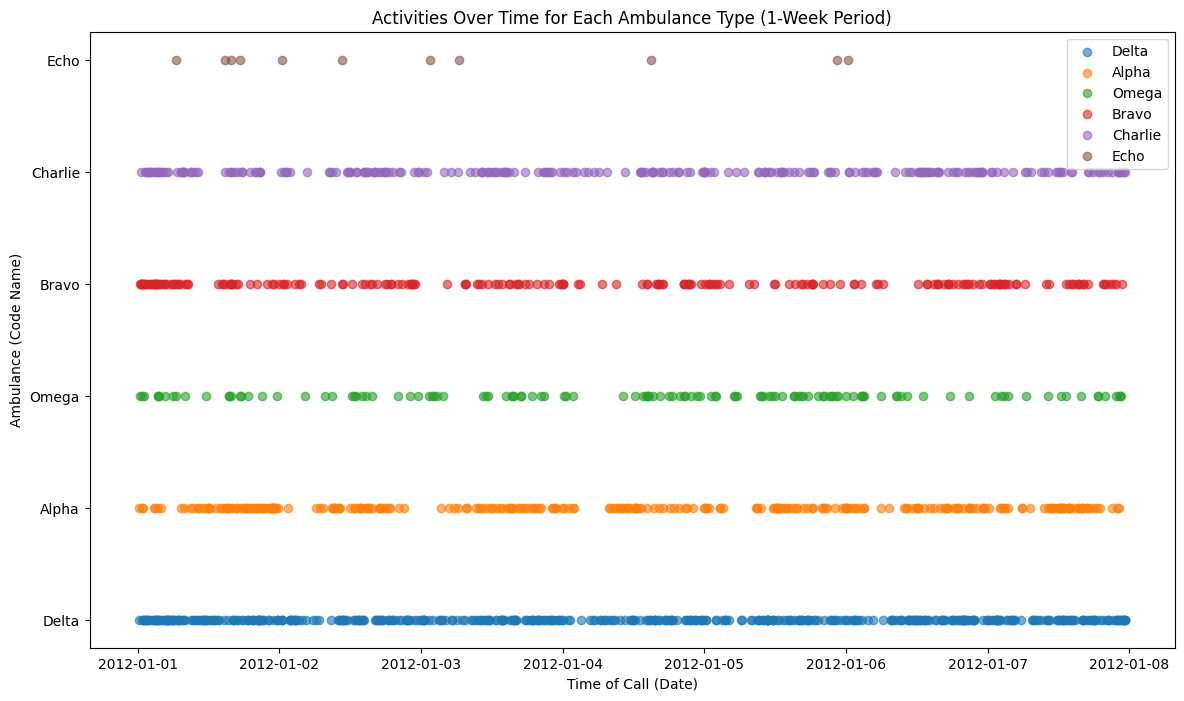

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

ambulance_types = action_log['Description'].unique()

start_date = '2012-01-01 00:00:00'
end_date = '2012-01-07 23:59:59'

# 1-week data for every ambulance
week_filtered_data = action_log.loc[(action_log['Date'] >= start_date) & (action_log['Date'] <= end_date) & (action_log['Activity'] == 'TimeOfCall')]

plt.figure(figsize=(14, 8))

# plot data
for ambulance_type in ambulance_types:
    subset = week_filtered_data.loc[week_filtered_data['Description'] == ambulance_type]
    plt.scatter(subset['Date'], [ambulance_type] * len(subset), label=ambulance_type, alpha=0.6)

plt.title('Activities Over Time for Each Ambulance Type (1-Week Period)')
plt.xlabel('Time of Call (Date)')
plt.yticks(ticks=range(len(ambulance_types)), labels=ambulance_types)
plt.ylabel('Ambulance (Code Name)')
plt.legend()
plt.show()

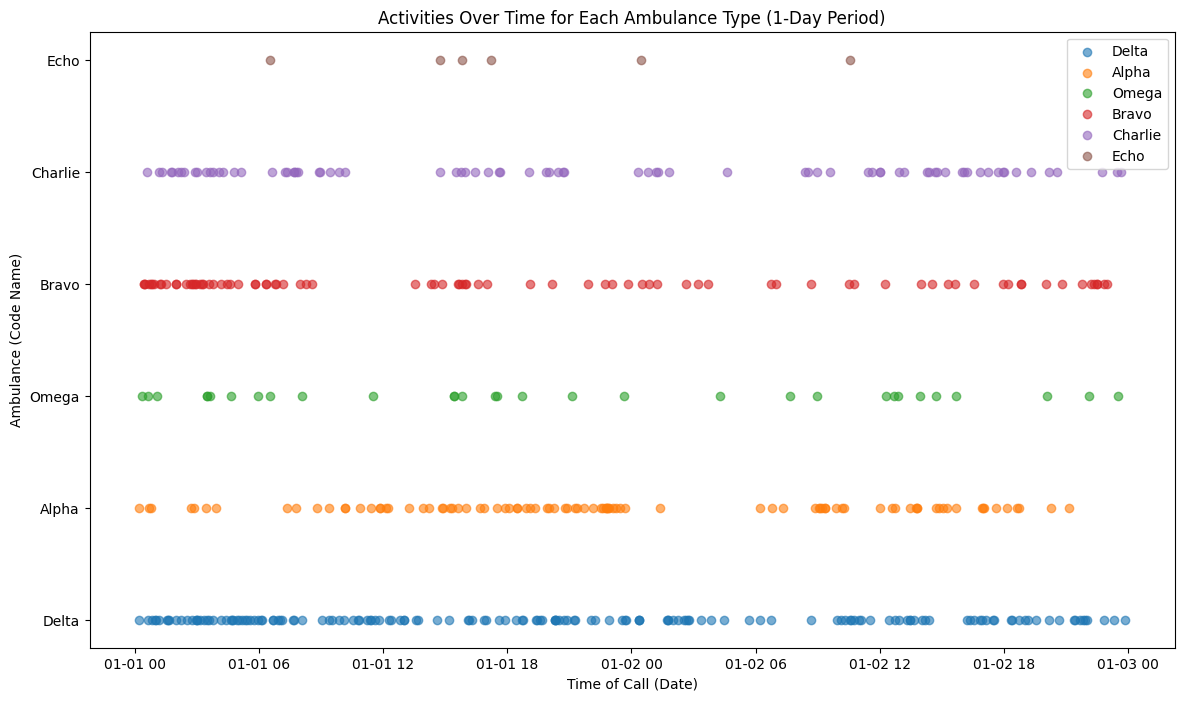

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

ambulance_types = action_log['Description'].unique()

start_date = '2012-01-01 00:00:00'
end_date = '2012-01-02 23:59:59'

# 1-day data for every ambulance
day_filtered_data = action_log.loc[(action_log['Date'] >= start_date) & (action_log['Date'] <= end_date) & (action_log['Activity'] == 'TimeOfCall')]

plt.figure(figsize=(14, 8))

# plot data
for ambulance_type in ambulance_types:
    subset = day_filtered_data.loc[day_filtered_data['Description'] == ambulance_type]
    plt.scatter(subset['Date'], [ambulance_type] * len(subset), label=ambulance_type, alpha=0.6)

plt.title('Activities Over Time for Each Ambulance Type (1-Day Period)')
plt.xlabel('Time of Call (Date)')
plt.yticks(ticks=range(len(ambulance_types)), labels=ambulance_types)
plt.ylabel('Ambulance (Code Name)')
plt.legend()
plt.show()

## 4. Conversion

- Transforming the dataset into an event log, a format suitable for process mining

In [37]:
start_month = '2012-01-01 00:00:00'
end_month = '2012-01-31 00:00:00'
start_week = '2012-01-01 00:00:00'
end_week = '2012-07-01 00:00:00'
start_day = '2012-01-01 00:00:00'
end_day = '2012-01-02 00:00:00'

month_data = action_log.loc[(action_log['Date'] >= start_month) & (action_log['Date'] <= end_month)]
week_data = action_log.loc[(action_log['Date'] >= start_week) & (action_log['Date'] <= end_week)]
day_data = action_log.loc[(action_log['Date'] >= start_day) & (action_log['Date'] <= end_day)]

We need to filter out those events that does not end with `ClosingDown` such that all the events are ended.

In [38]:
year_log = pm4py.format_dataframe(action_log, case_id='Description', activity_key='Activity', timestamp_key='Date')
pm4py.filter_end_activities(year_log, ['ClosingDown'], activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

month_log = pm4py.format_dataframe(month_data, case_id='Description', activity_key='Activity', timestamp_key='Date')
pm4py.filter_end_activities(month_log, ['ClosingDown'], activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

week_log = pm4py.format_dataframe(week_data, case_id='Description', activity_key='Activity', timestamp_key='Date')
pm4py.filter_end_activities(week_log, ['ClosingDown'], activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

day_log = pm4py.format_dataframe(day_data, case_id='Description', activity_key='Activity', timestamp_key='Date')
pm4py.filter_end_activities(day_log, ['ClosingDown'], activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

,Date,Station Area,Description,Activity,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
399,2012-01-01 00:27:00+00:00,Kilbarrack,Bravo,TimeOfCall,Bravo,TimeOfCall,2012-01-01 00:27:00+00:00,399,1
400,2012-01-01 00:28:00+00:00,Tallaght,Bravo,TimeOfCall,Bravo,TimeOfCall,2012-01-01 00:28:00+00:00,400,1
401,2012-01-01 00:29:00+00:00,Kilbarrack,Bravo,OrderedTime,Bravo,OrderedTime,2012-01-01 00:29:00+00:00,401,1
402,2012-01-01 00:30:00+00:00,Dolphins Barn,Bravo,TimeOfCall,Bravo,TimeOfCall,2012-01-01 00:30:00+00:00,402,1
403,2012-01-01 00:31:00+00:00,Kilbarrack,Bravo,MobileToIncident,Bravo,MobileToIncident,2012-01-01 00:31:00+00:00,403,1
...,...,...,...,...,...,...,...,...,...
1788,2012-01-01 17:23:00+00:00,Dolphins Barn,Echo,InAttendance,Echo,InAttendance,2012-01-01 17:23:00+00:00,1788,4
1789,2012-01-01 17:28:00+00:00,Dolphins Barn,Echo,LeavingScene,Echo,LeavingScene,2012-01-01 17:28:00+00:00,1789,4
1790,2012-01-01 17:28:00+00:00,Dolphins Barn,Echo,AtHospital,Echo,AtHospital,2012-01-01 17:28:00+00:00,1790,4
1791,2012-01-01 17:30:00+00:00,Dolphins Barn,Echo,MobileAndAvailable,Echo,MobileAndAvailable,2012-01-01 17:30:00+00:00,1791,4


In [39]:
filtered_year_log = year_log[year_log['Activity'] != 'ClosingDown']
filtered_month_log = month_log[month_log['Activity'] != 'ClosingDown']
filtered_week_log = week_log[week_log['Activity'] != 'ClosingDown']
filtered_day_log = day_log[day_log['Activity'] != 'ClosingDown']

In [40]:
log_start = pm4py.get_start_activities(filtered_year_log)
log_end = pm4py.get_end_activities(filtered_year_log)

print('Start activity\n', log_start)
print('End activity\n', log_end)

Start activity
 {'TimeOfCall': 6}
End activity
 {'MobileAndAvailable': 6}


## 5. Process Discovery

It is useful to analyze the actions of few ambulances instead of analyzing all the ambulances at once. We will analyze **Echo** and **Omega**.

In [41]:
# echo event logs
echo_log_day = day_log[day_log['Description'] == 'Echo']
echo_log_week = week_log[week_log['Description'] == 'Echo']
echo_log_month = month_log[month_log['Description'] == 'Echo']

In [42]:
# omega event logs
omega_log_day = day_log[day_log['Description'] == 'Omega']
omega_log_week = week_log[week_log['Description'] == 'Omega']
omega_log_month = month_log[month_log['Description'] == 'Omega']

### Inductive Petri Net

#### 1-day event log

Inductive Petri Net for Echo 1-day event log



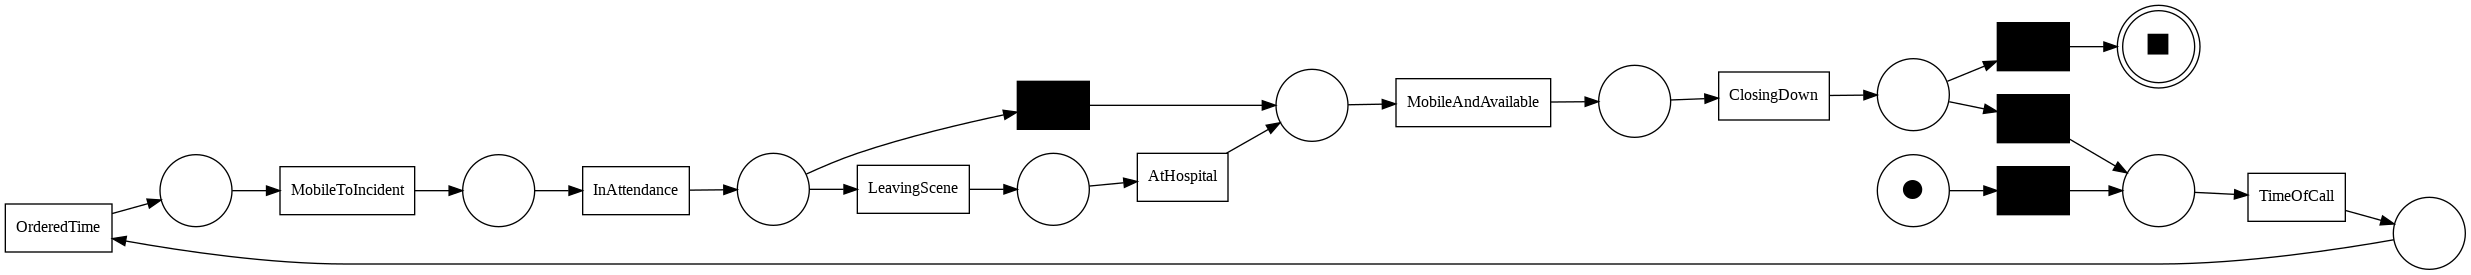

In [43]:
inet, ind_start, ind_end = pm4py.discover_petri_net_inductive(echo_log_day)

print('Inductive Petri Net for Echo 1-day event log\n')
pm4py.view_petri_net(inet, ind_start, ind_end)

Inductive Petri Net for Omega 1-day event log



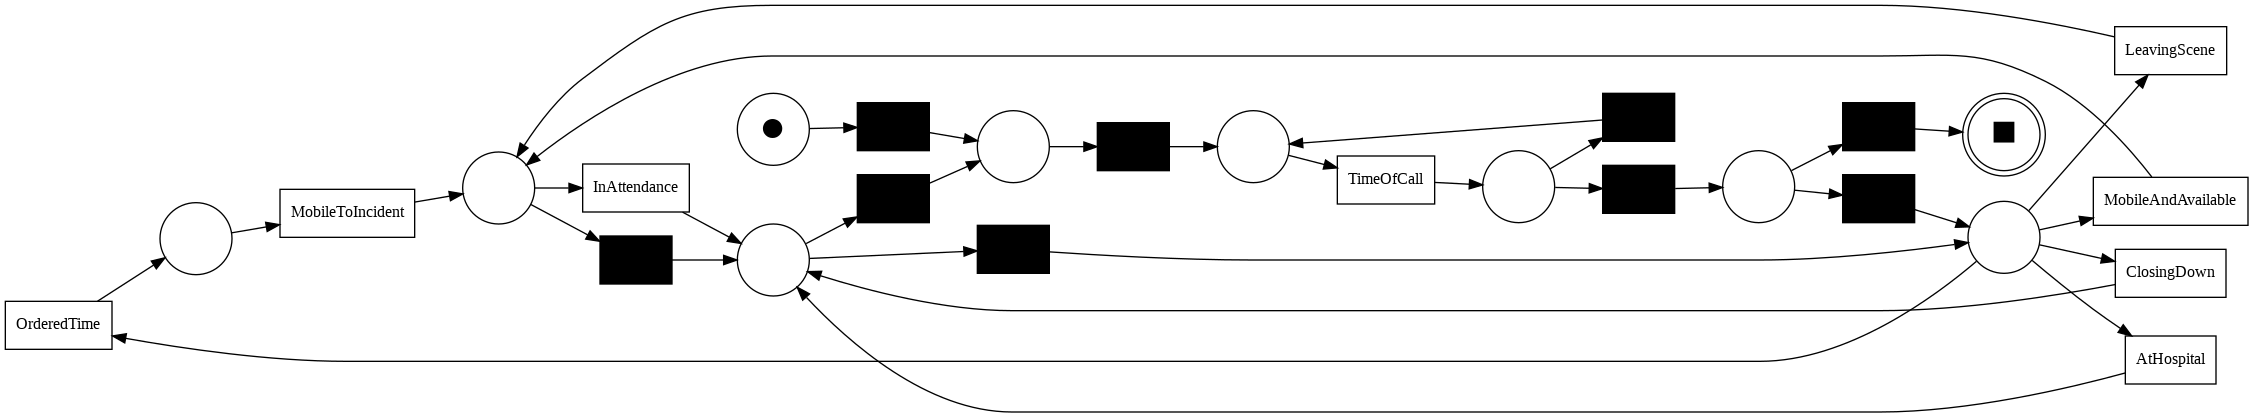

In [44]:
inet, ind_start, ind_end = pm4py.discover_petri_net_inductive(omega_log_day)

print('Inductive Petri Net for Omega 1-day event log\n')
pm4py.view_petri_net(inet, ind_start, ind_end)

#### 1-week event log

Inductive Petri Net for Echo 1-week event log



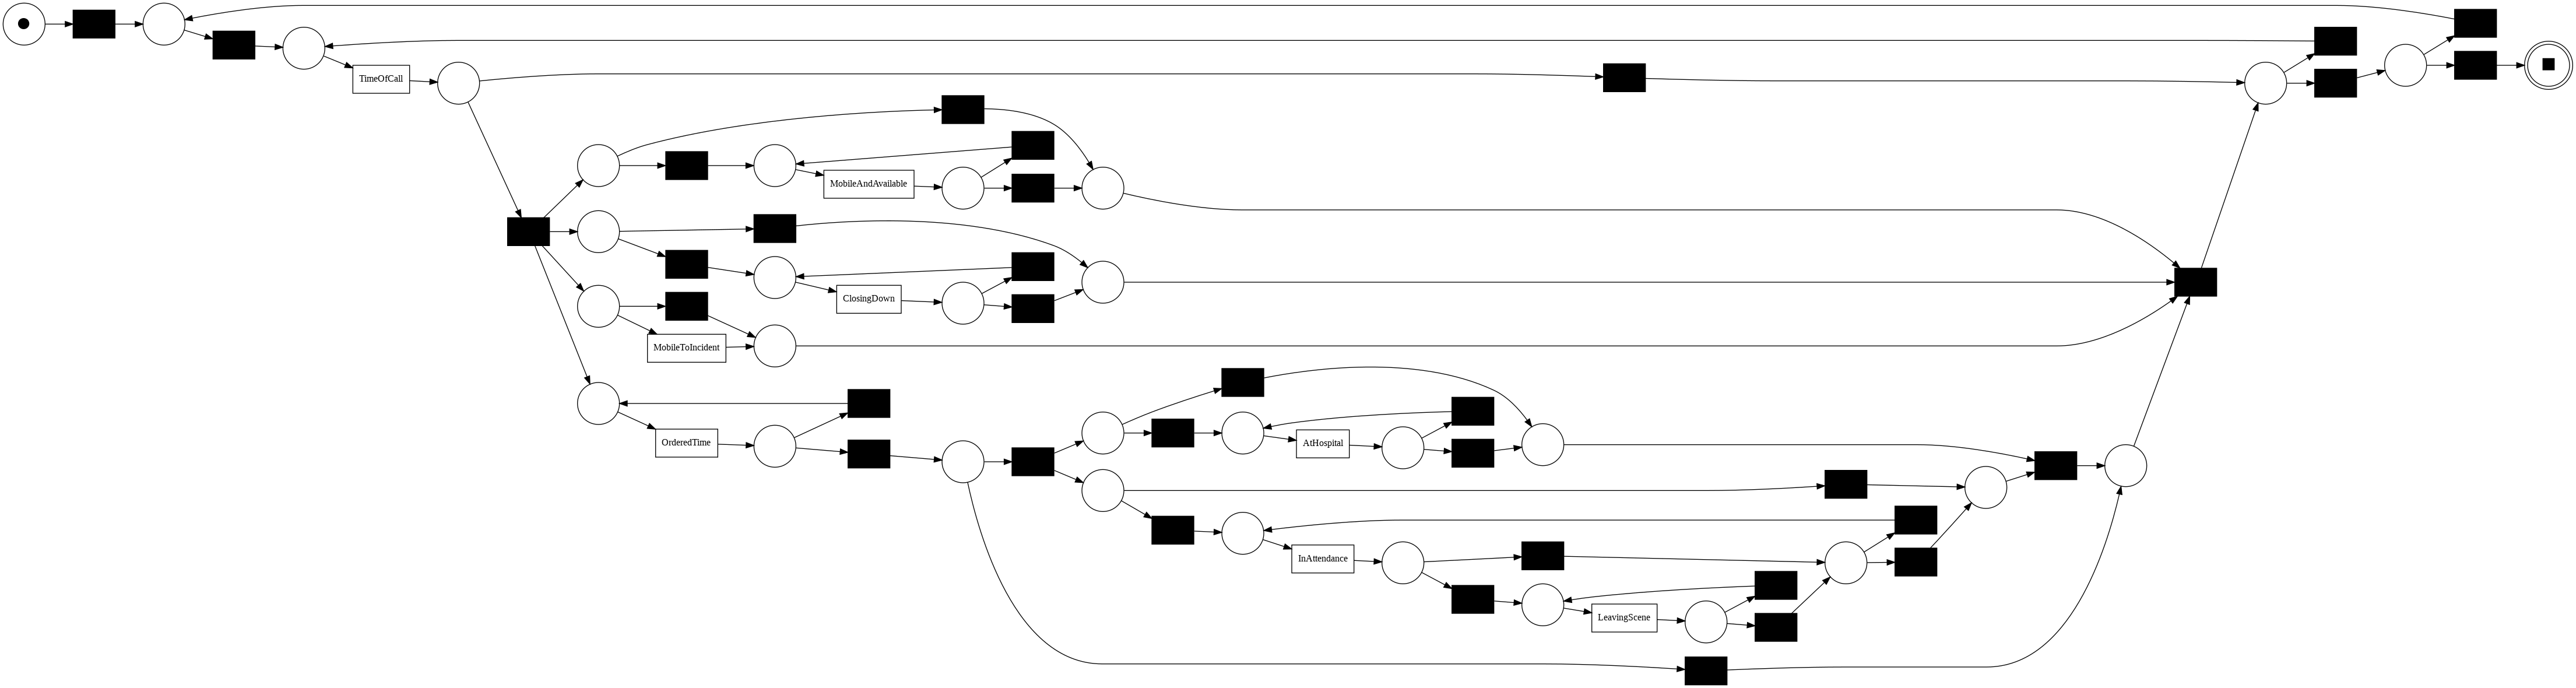

In [45]:
inet, ind_start, ind_end = pm4py.discover_petri_net_inductive(echo_log_week)

print('Inductive Petri Net for Echo 1-week event log\n')
pm4py.view_petri_net(inet, ind_start, ind_end)

Inductive Petri Net for Omega 1-week event log



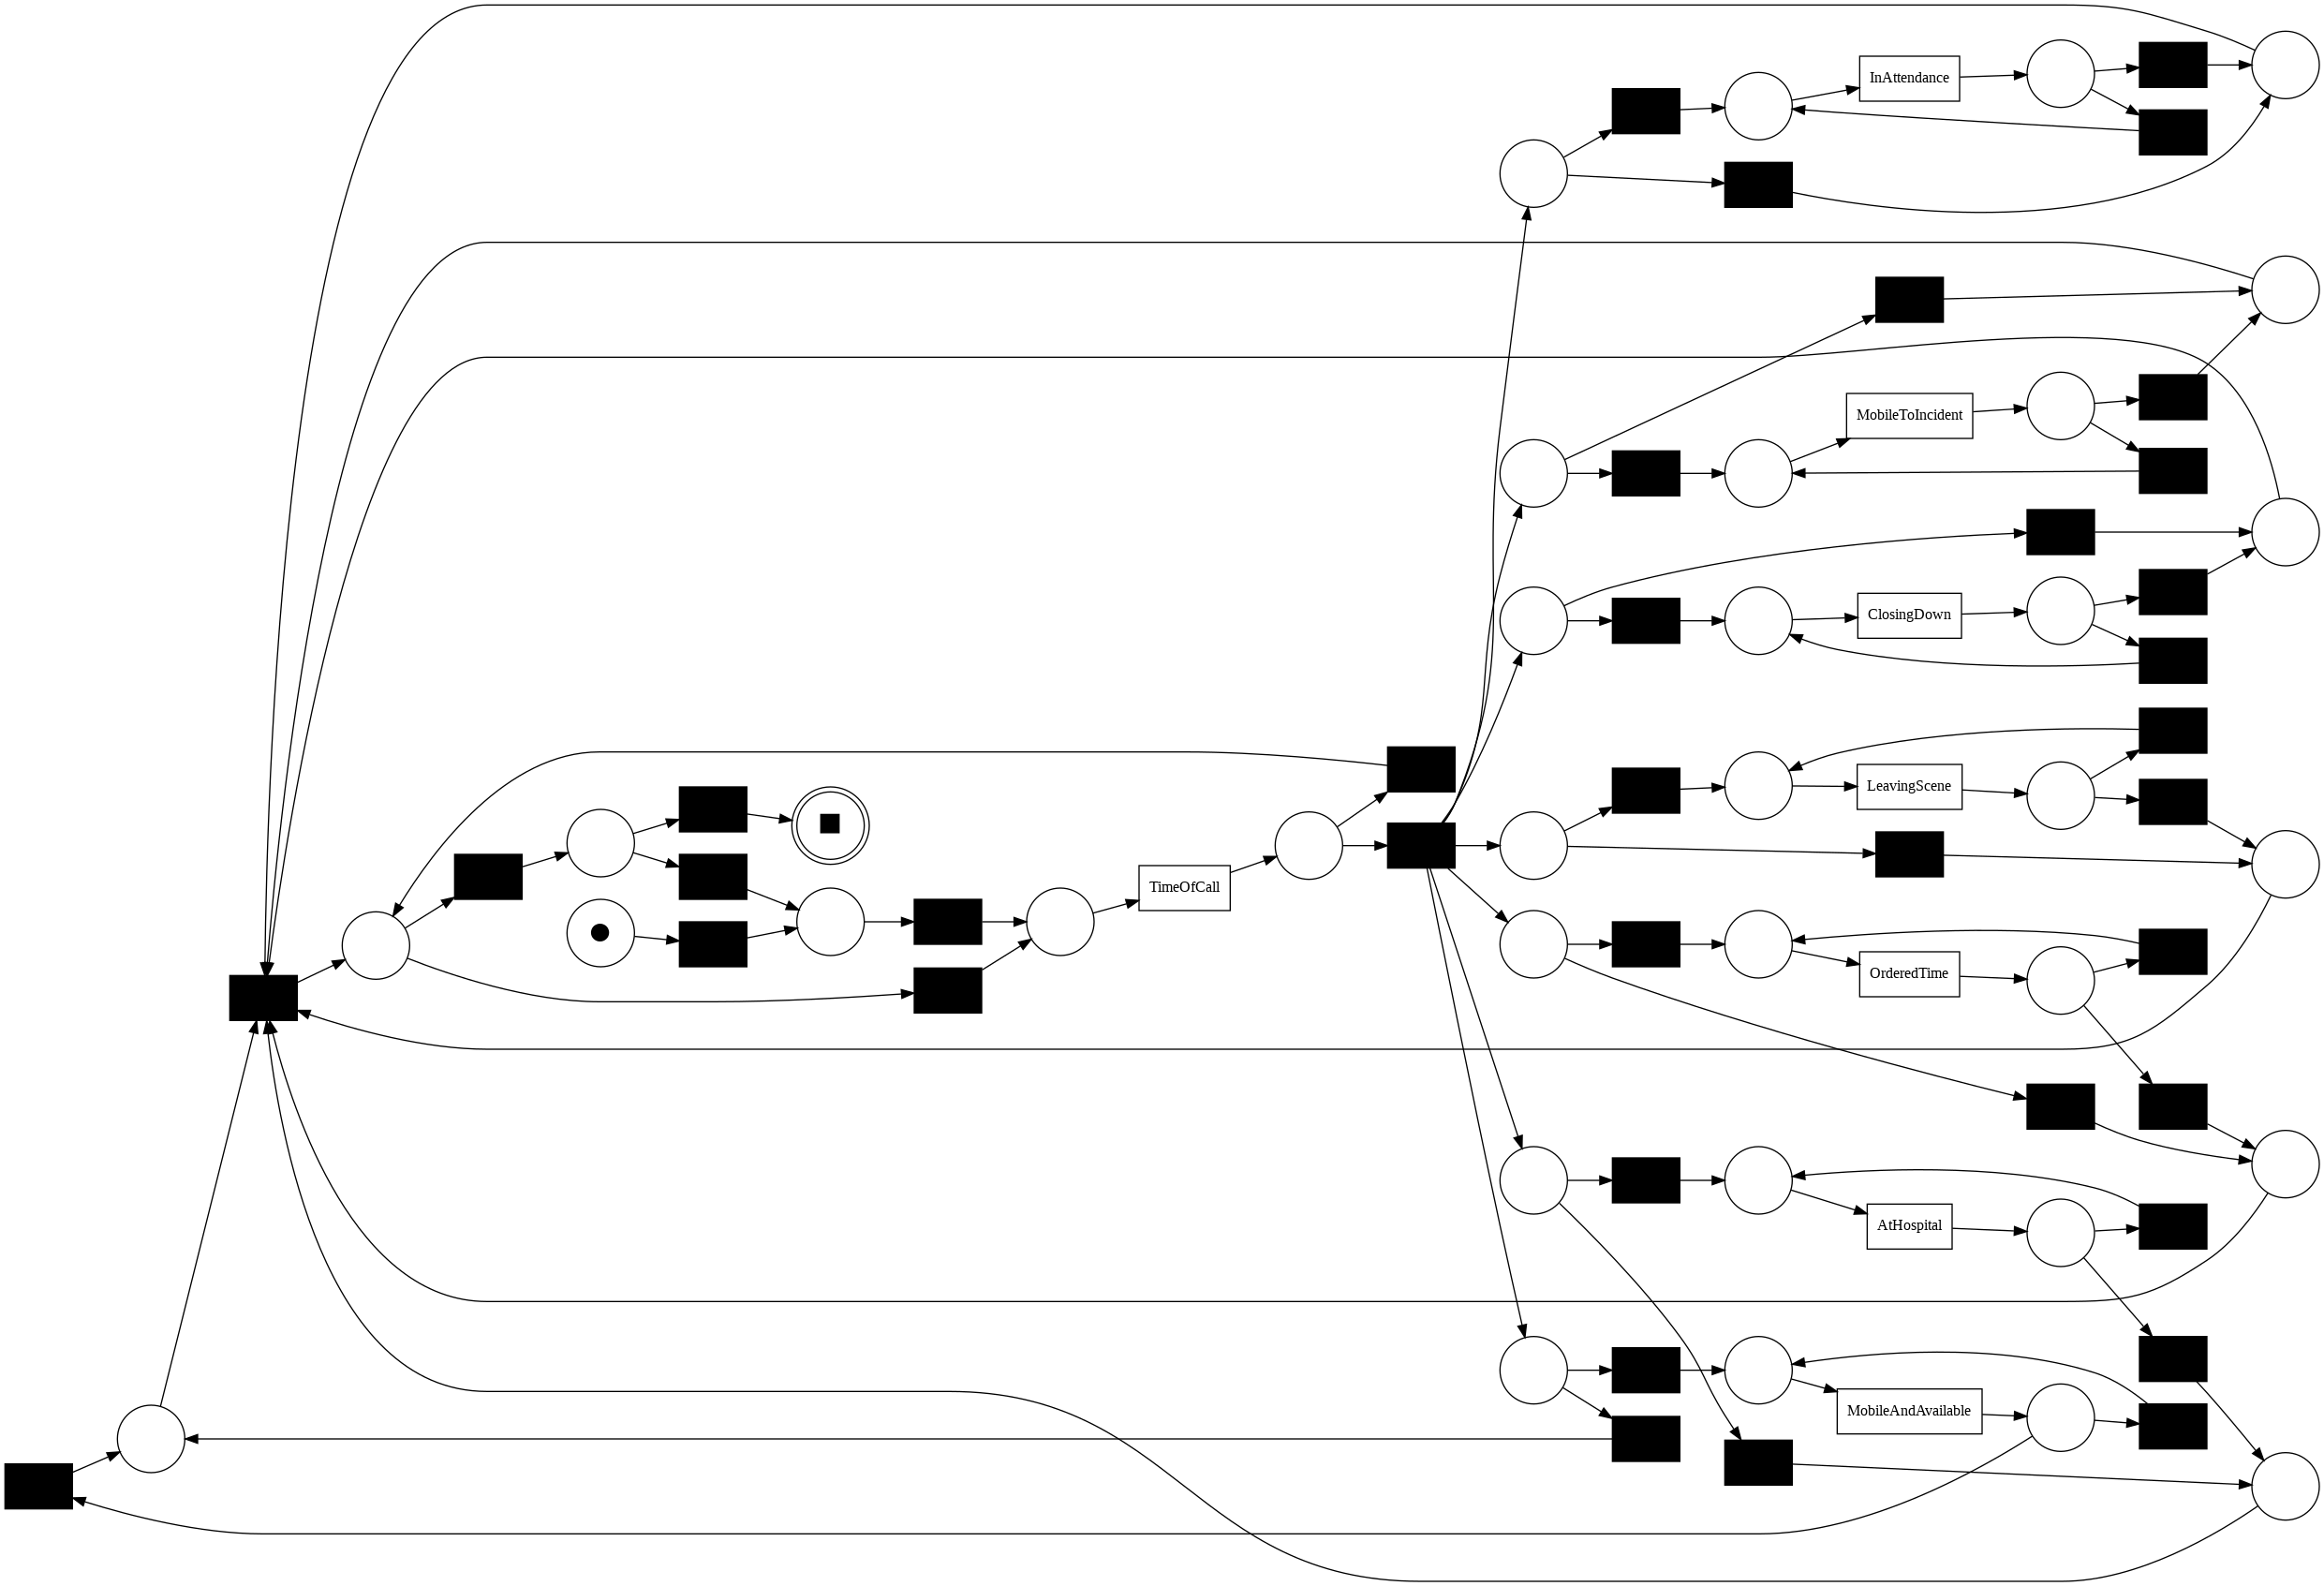

In [46]:
inet, ind_start, ind_end = pm4py.discover_petri_net_inductive(omega_log_week)

print('Inductive Petri Net for Omega 1-week event log\n')
pm4py.view_petri_net(inet, ind_start, ind_end)

#### 1-month event log

Inductive Petri Net for Echo 1-month event log



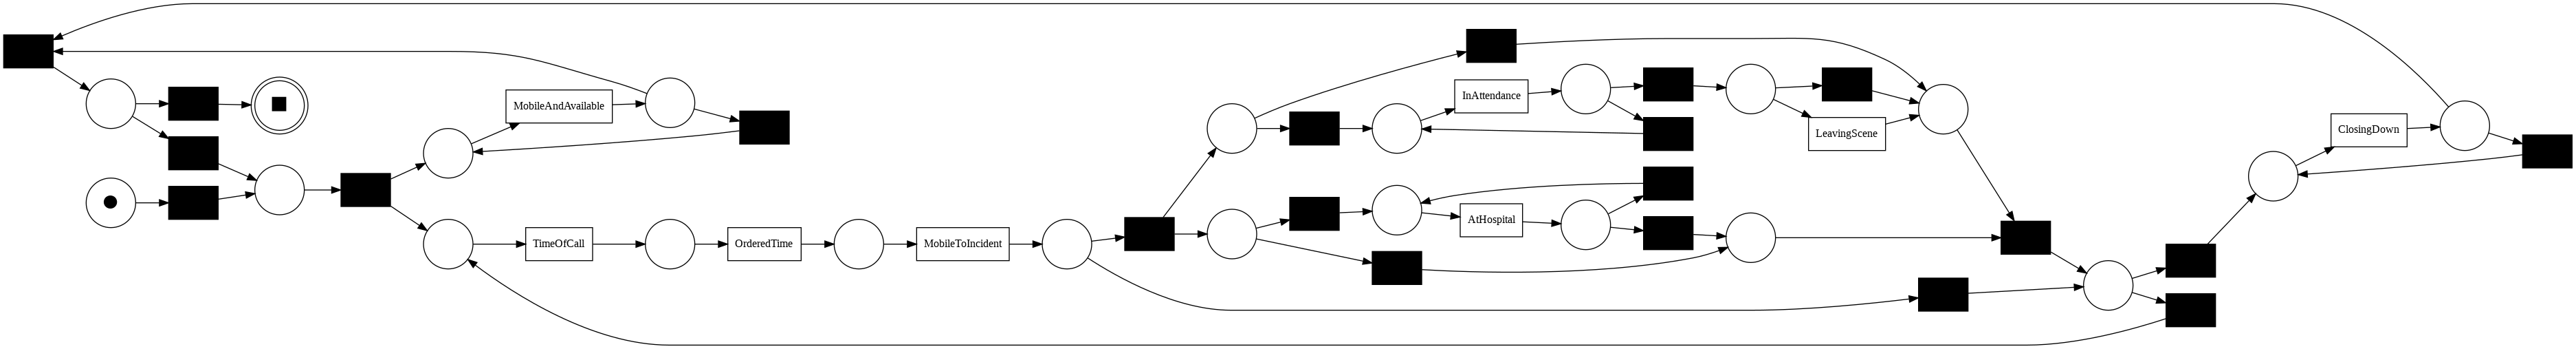

In [47]:
inet, ind_start, ind_end = pm4py.discover_petri_net_inductive(echo_log_month)

print('Inductive Petri Net for Echo 1-month event log\n')
pm4py.view_petri_net(inet, ind_start, ind_end)

Inductive Petri Net for Omega 1-month event log



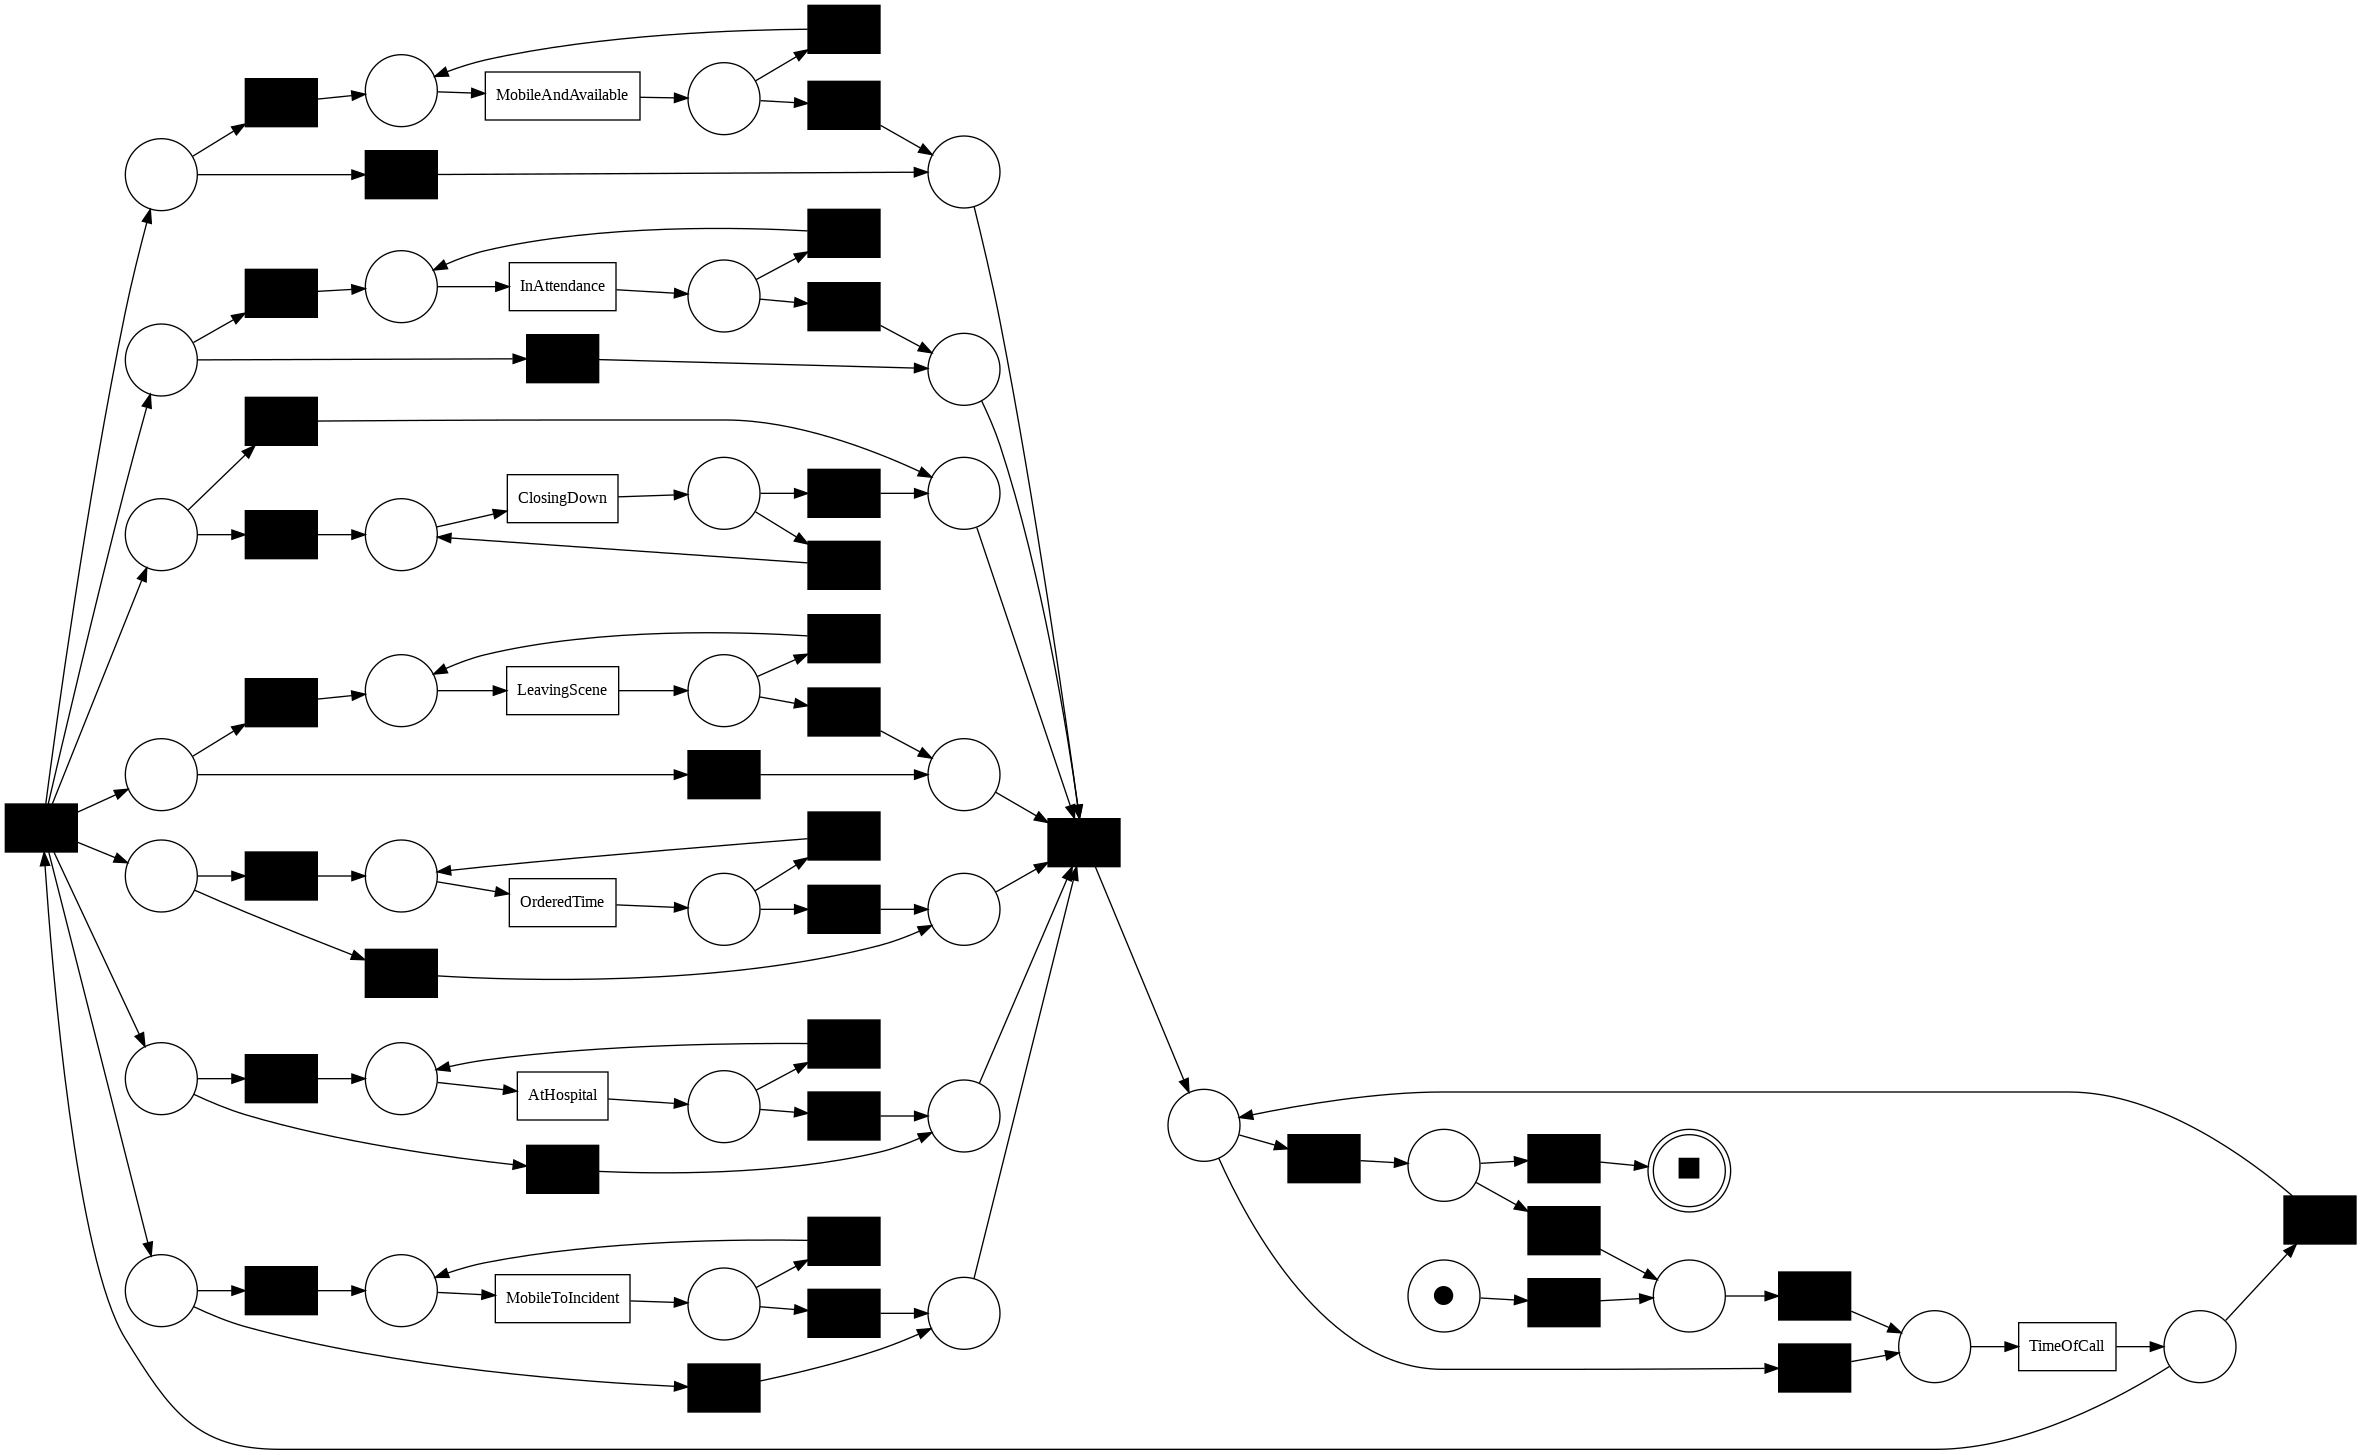

In [48]:
inet, ind_start, ind_end = pm4py.discover_petri_net_inductive(omega_log_month)

print('Inductive Petri Net for Omega 1-month event log\n')
pm4py.view_petri_net(inet, ind_start, ind_end)

### Heuristic Petri Net

Heuristic Petri Net for Echo 1-day event log



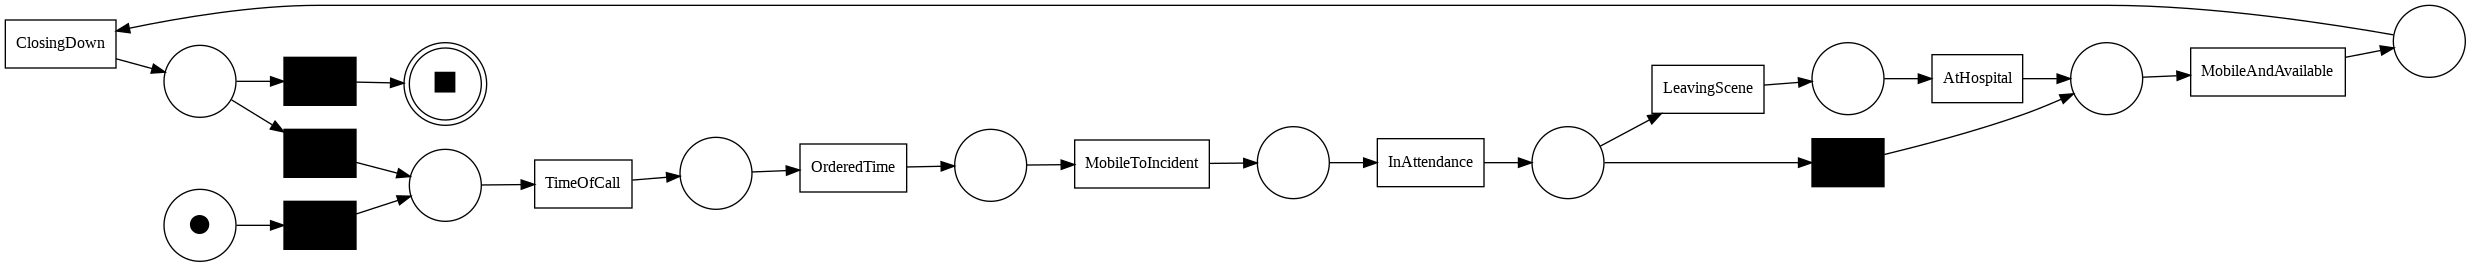

In [49]:
hnet, start, end = pm4py.discover_petri_net_heuristics(echo_log_day)

print('Heuristic Petri Net for Echo 1-day event log\n')
pm4py.view_petri_net(hnet, start, end)

Heuristic Petri Net for Omega 1-day event log



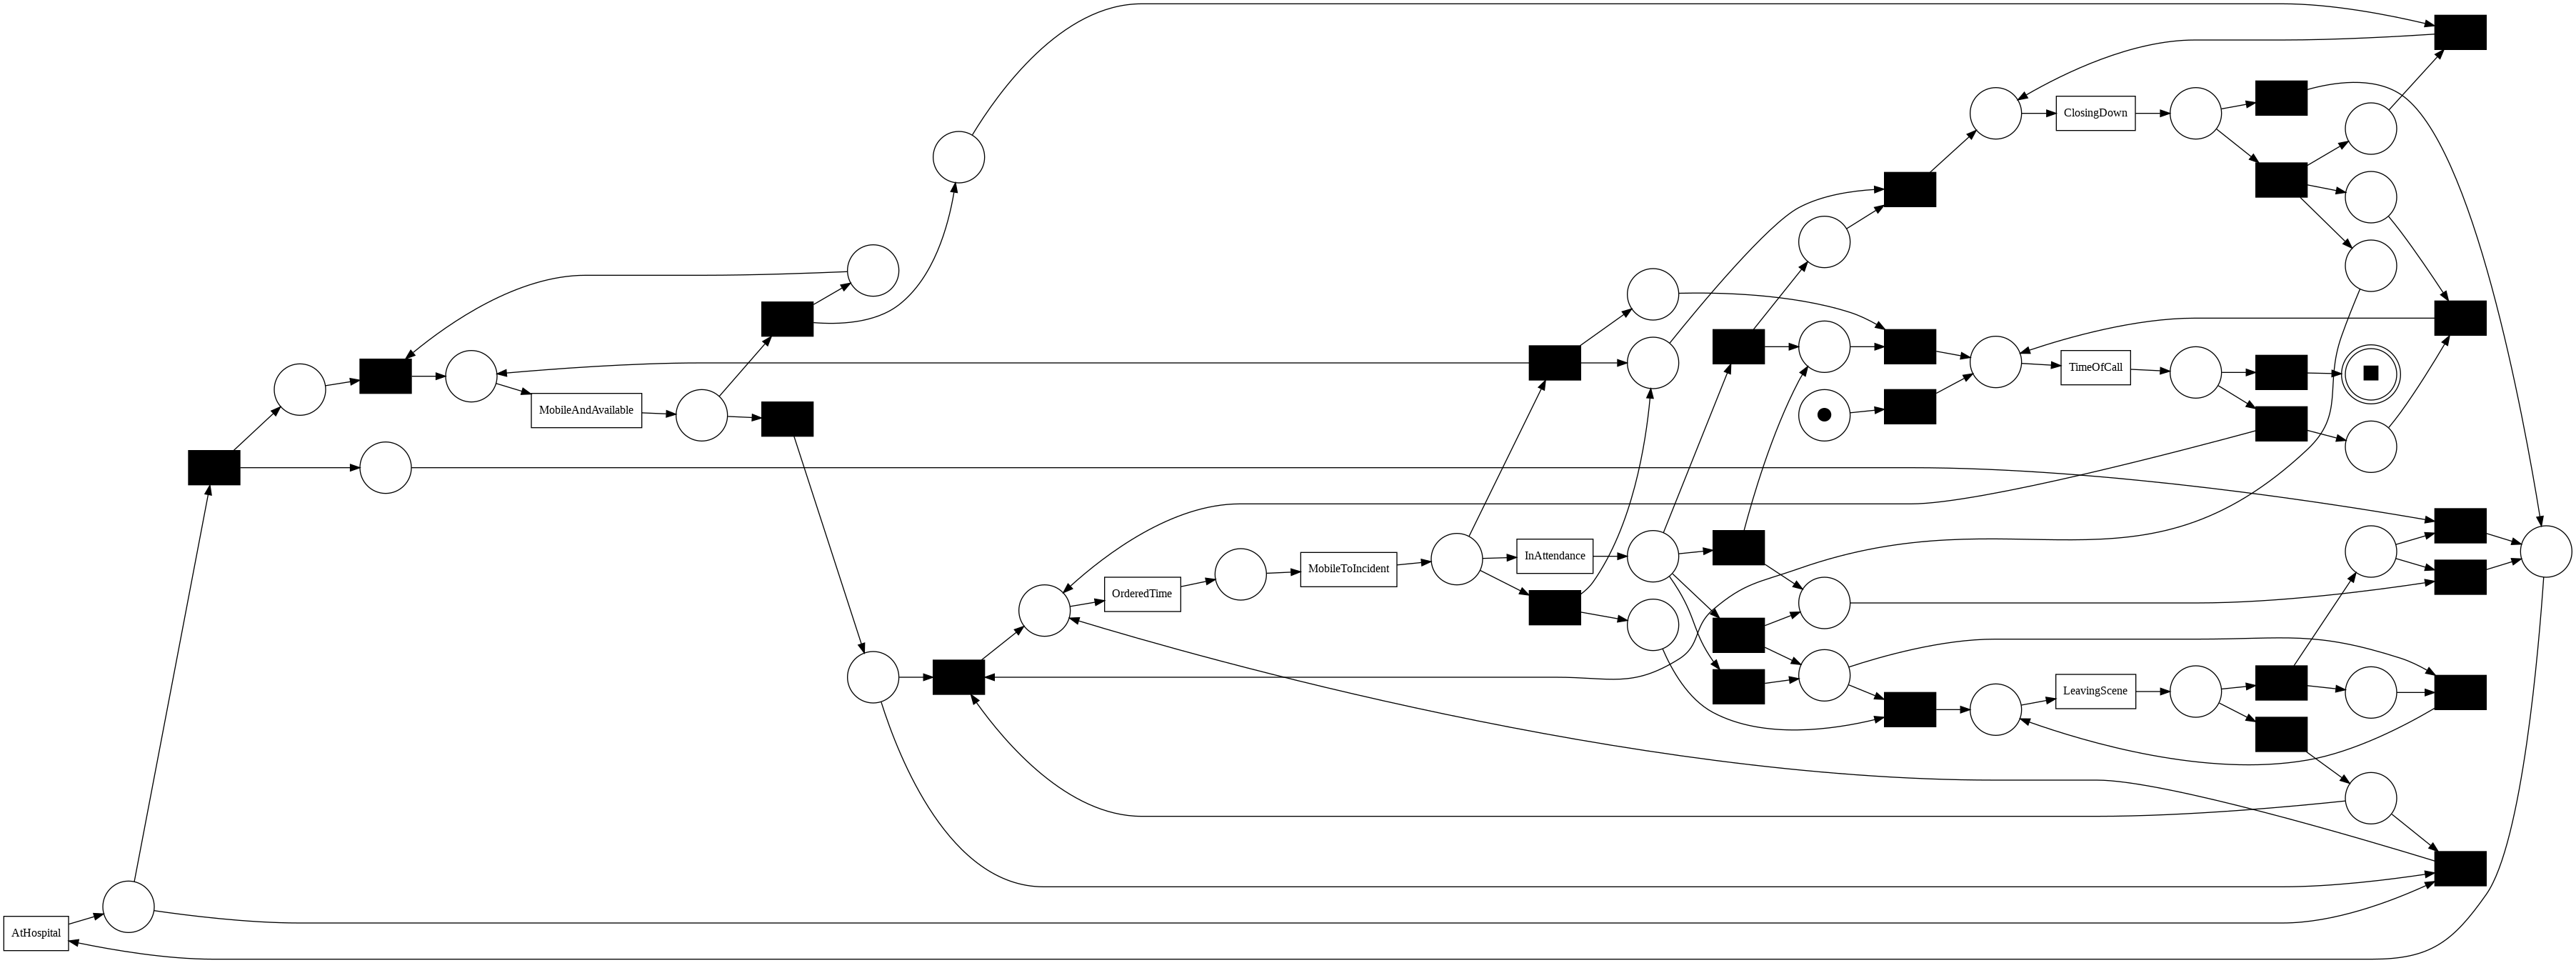

In [50]:
hnet, start, end = pm4py.discover_petri_net_heuristics(omega_log_day)

print('Heuristic Petri Net for Omega 1-day event log\n')
pm4py.view_petri_net(hnet, start, end)

### Heuristic Net

Heuristic Net for Echo 1-day event log



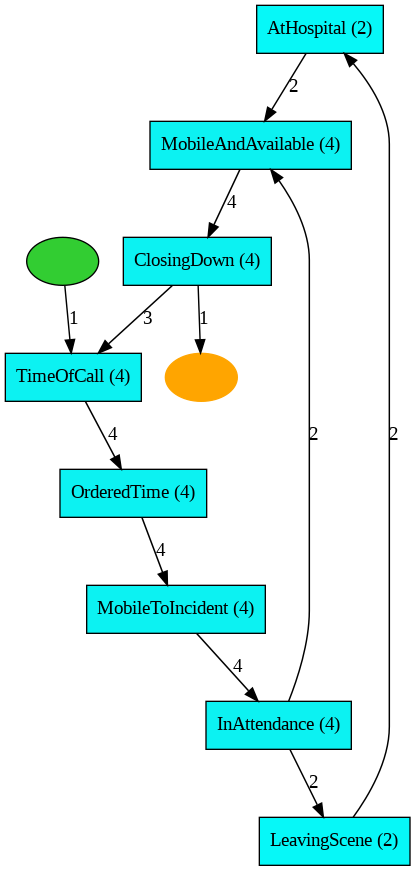

In [51]:
heu = pm4py.discover_heuristics_net(echo_log_day)

print('Heuristic Net for Echo 1-day event log\n')
pm4py.view_heuristics_net(heu)

Heuristic Net for Omega 1-day event log



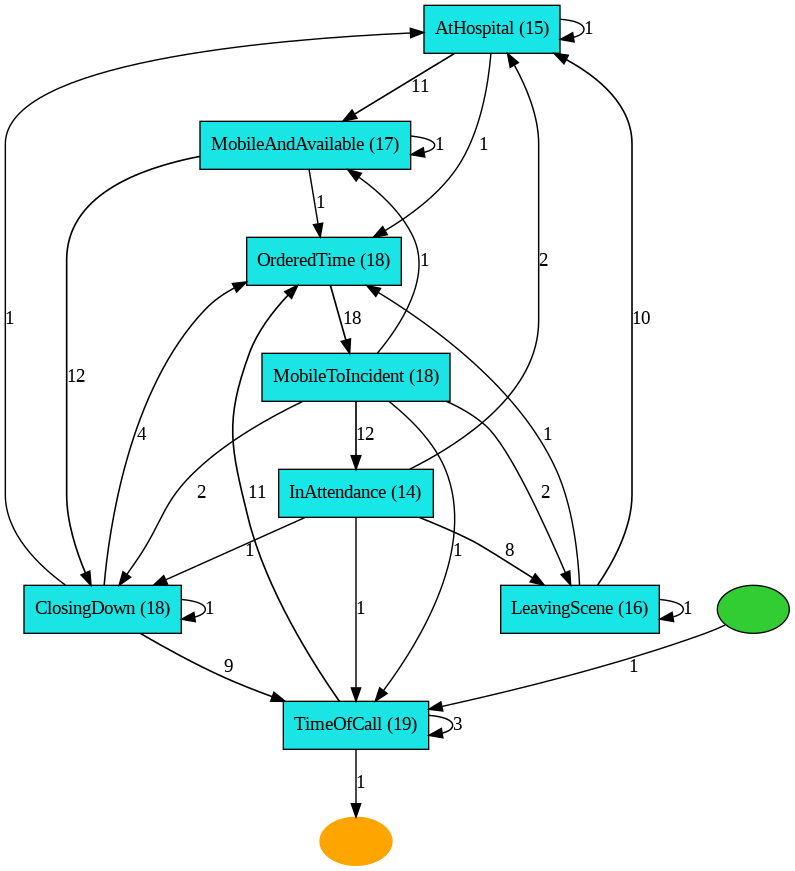

In [52]:
heu = pm4py.discover_heuristics_net(omega_log_day)

print('Heuristic Net for Omega 1-day event log\n')
pm4py.view_heuristics_net(heu)

## 6. Conformance checking

For the last step, we check some properties of the Inductive Petri Nets that we have discovered for Echo and Omega on the 1-day event logs.

1. Fitness
2. Precision
3. Simplicity
4. Generalization



In [53]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

In [54]:
inet, ind_start, ind_end = pm4py.discover_petri_net_inductive(echo_log_day)
tbr_diagnostics = pm4py.conformance_diagnostics_token_based_replay(echo_log_day, inet, ind_start, ind_end, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

In [55]:
print('Echo diagnostics\n')
print('Is trace fit?', tbr_diagnostics[0]['trace_is_fit'])
print('Reached marking', tbr_diagnostics[0]['reached_marking'])
print('Missing tokens:', tbr_diagnostics[0]['missing_tokens'])
print('Consumed tokens:', tbr_diagnostics[0]['consumed_tokens'])
print('Remaining tokens:', tbr_diagnostics[0]['remaining_tokens'])
print('Produced tokens:', tbr_diagnostics[0]['produced_tokens'])

Echo diagnostics

Is trace fit? True
Reached marking ['sink:1']
Missing tokens: 0
Consumed tokens: 36
Remaining tokens: 0
Produced tokens: 36


In [56]:
fitness_tbr = pm4py.fitness_token_based_replay(echo_log_day, inet, ind_start, ind_end, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

In [57]:
prec = pm4py.precision_token_based_replay(echo_log_day, inet, ind_start, ind_end)

replaying log with TBR, completed traces ::   0%|          | 0/27 [00:00<?, ?it/s]

In [58]:
gen = generalization_evaluator.apply(echo_log_day, inet, ind_start, ind_end)

In [59]:
simp = simplicity_evaluator.apply(inet)

In [60]:
print('Echo results')
print('Fitness\n', fitness_tbr)
print('Precision\n', prec)
print('Generalization\n', gen)
print('Simplicity\n', simp)

Echo results
Fitness
 {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
Precision
 0.9322033898305084
Generalization
 0.3584441156042276
Simplicity
 0.92


In [61]:
inet, ind_start, ind_end = pm4py.discover_petri_net_inductive(omega_log_day)
tbr_diagnostics = pm4py.conformance_diagnostics_token_based_replay(omega_log_day, inet, ind_start, ind_end, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

In [62]:
print('Omega diagnostics\n')
print('Is trace fit?', tbr_diagnostics[0]['trace_is_fit'])
print('Reached marking', tbr_diagnostics[0]['reached_marking'])
print('Missing tokens:', tbr_diagnostics[0]['missing_tokens'])
print('Consumed tokens:', tbr_diagnostics[0]['consumed_tokens'])
print('Remaining tokens:', tbr_diagnostics[0]['remaining_tokens'])
print('Produced tokens:', tbr_diagnostics[0]['produced_tokens'])

Omega diagnostics

Is trace fit? True
Reached marking ['sink:1']
Missing tokens: 0
Consumed tokens: 309
Remaining tokens: 0
Produced tokens: 309


In [63]:
fitness_tbr = pm4py.fitness_token_based_replay(omega_log_day, inet, ind_start, ind_end, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

In [64]:
prec = pm4py.precision_token_based_replay(omega_log_day, inet, ind_start, ind_end)

replaying log with TBR, completed traces ::   0%|          | 0/134 [00:00<?, ?it/s]

In [65]:
gen = generalization_evaluator.apply(omega_log_day, inet, ind_start, ind_end)

In [66]:
simp = simplicity_evaluator.apply(inet)

In [67]:
print('Omega results')
print('Fitness\n', fitness_tbr)
print('Precision\n', prec)
print('Generalization\n', gen)
print('Simplicity\n', simp)

Omega results
Fitness
 {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
Precision
 0.29888888888888887
Generalization
 0.6568793434806999
Simplicity
 0.6585365853658536
